In [1]:
# Import packages
import tensorflow as tf
import os, sys
import warnings
import dataloader_tf as dataloader
import numpy as np
from tensorflow.nn import weighted_cross_entropy_with_logits as loss_fn
import datetime
import tensorflow_models as tfm
from tensorflow_models import vision
from keras import layers
from keras.layers import Input, Activation, ZeroPadding2D, BatchNormalization, Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras import regularizers
import matplotlib.pyplot as plt

from keras.layers import Layer
import tensorflow_addons as tfa

%matplotlib inline

2023-04-21 22:06:28.223667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tshah74/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-04-21 22:06:33.179868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 22:06:33.217909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 22:06:33.218142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 22:06:33.219095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
# Load dataset with batch size sequence of frames in each sequence

BATCH_SIZE = 8
SEQUENCE_DEPTH = 16

dataset = dataloader.CholecT50( 
          dataset_dir="CholecT50/", 
          dataset_variant="cholect50",
          test_fold=1,
          augmentation_list=['original'],
          num_parallel_calls=100,
          num_sequence = SEQUENCE_DEPTH
          )

In [4]:
# Given instruments in the dataset
instruments = np.array([
    "Grasper",
    "Bipolar",
    "Hook",
    "Scissors",
    "Clipper",
    "Irrigator"
])

In [5]:
# build dataset
train_dataset, val_dataset, test_dataset = dataset.build()

# train and val data loaders
train_dataloader = train_dataset.batch(BATCH_SIZE) # see tf.data.Dataset for more options
val_dataloader   = val_dataset.batch(BATCH_SIZE)

# test data set is built per video, so load differently
test_dataloaders = []
for video_dataset in test_dataset:
    test_dataloader = video_dataset.batch(BATCH_SIZE)
    test_dataloaders.append(test_dataloader)  
    
train_dataloader = train_dataloader.prefetch(tf.data.AUTOTUNE)
val_dataloader = val_dataloader.prefetch(tf.data.AUTOTUNE)

In [6]:
# Set up for Training 
class_weights = tf.convert_to_tensor(
    [0.08084519, 0.81435289, 0.10459284, 2.55976864, 1.630372490, 1.29528455], 
    dtype=tf.float32, dtype_hint=None, name=None
)

In [7]:
from tensorflow import keras
model = keras.models.load_model('/home/tshah74/mip/WeakLSTM/code/Model_PretrainResNet_Complete_Dataset_100_Epochs')

In [8]:
model.summary()

Model: "WNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 256, 44  0           []                               
                                8, 3)]                                                            
                                                                                                  
 time_distributed (TimeDistribu  (None, 16, 8, 14, 5  11186889   ['input_1[0][0]']                
 ted)                           12)                                                               
                                                                                                  
 convLSTMLayer (ConvLSTM2D)     (None, 16, 8, 14, 6  12456       ['time_distributed[0][0]']       
                                )                                                              

In [9]:
import cv2
# plt.tight_layout()
# plt.subplots_adjust(hspace=0)
for (img_list, (_, label_i, _, _, _)) in train_dataloader.take(1):
    [logits_list, LHMaps] = model(img_list, training=False)

[869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 10

2023-04-21 22:06:59.277754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-04-21 22:07:01.874999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.10321891, shape=(), dtype=float32)
(8, 14)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.10373915, shape=(), dtype=float32)
(8, 14)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.10293889, shape=(), dtype=float32)
(8, 14)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09614622, shape=(), dtype=float32)
(8, 14)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09933021, shape=(), dtype=float32)
(8, 14)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.10286475, shape=(), dtype=float32)
(8, 14)


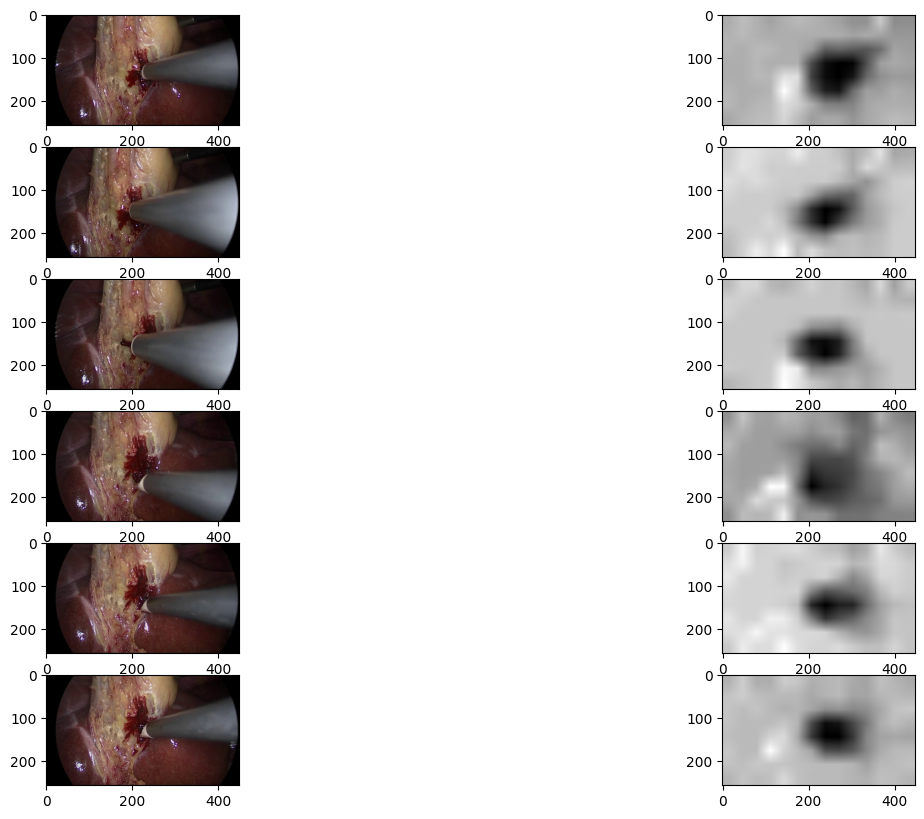

In [10]:
plt.subplots(6,2,figsize=(16,10))
# Iterate over frames in the batch sequence
for idx in range(0, 6):

    offset = 10
    # Get frame
    img = img_list[0][idx+offset]
    # Get groundtruth label for frame
    label = label_i[0][idx+offset]
    plt.subplot(6,2,2*idx+1)
    plt.imshow(img.numpy().astype(np.uint8))
    print(label)

    logits = logits_list[0][idx+offset]
    logit  = tf.sigmoid(logits)

    # print(logit)

    loss_value = loss_fn(labels=label, logits=logits, pos_weight=class_weights)
    loss_value = tf.math.reduce_mean(loss_value)
    print("Loss Value")
    print(loss_value)

    plt.subplot(6,2,2*idx+2)
    heatmap = LHMaps[0][idx+offset][:,:,0].numpy() * label[0].numpy()
    print(heatmap.shape)
    heatmap = cv2.resize(heatmap, dsize=(448, 256), interpolation=cv2.INTER_LINEAR)
    
    heatmap = ((heatmap - heatmap.min()) * (1/(heatmap.max() - heatmap.min()) * 255)).astype('uint8')
    heatmap = cv2.merge((heatmap,heatmap,heatmap))
    
    
    # super_imposed_img = cv2.addWeighted(heatmap, 0.5, img.numpy().astype(np.uint8), 0.5, 0)
    plt.imshow(heatmap)

tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.12405736, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.101622045, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.10152477, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09923017, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09853157, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09487153, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09603112, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf.Tensor(0.09923812, shape=(), dtype=float32)
tf.Tensor([1. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Loss Value
tf

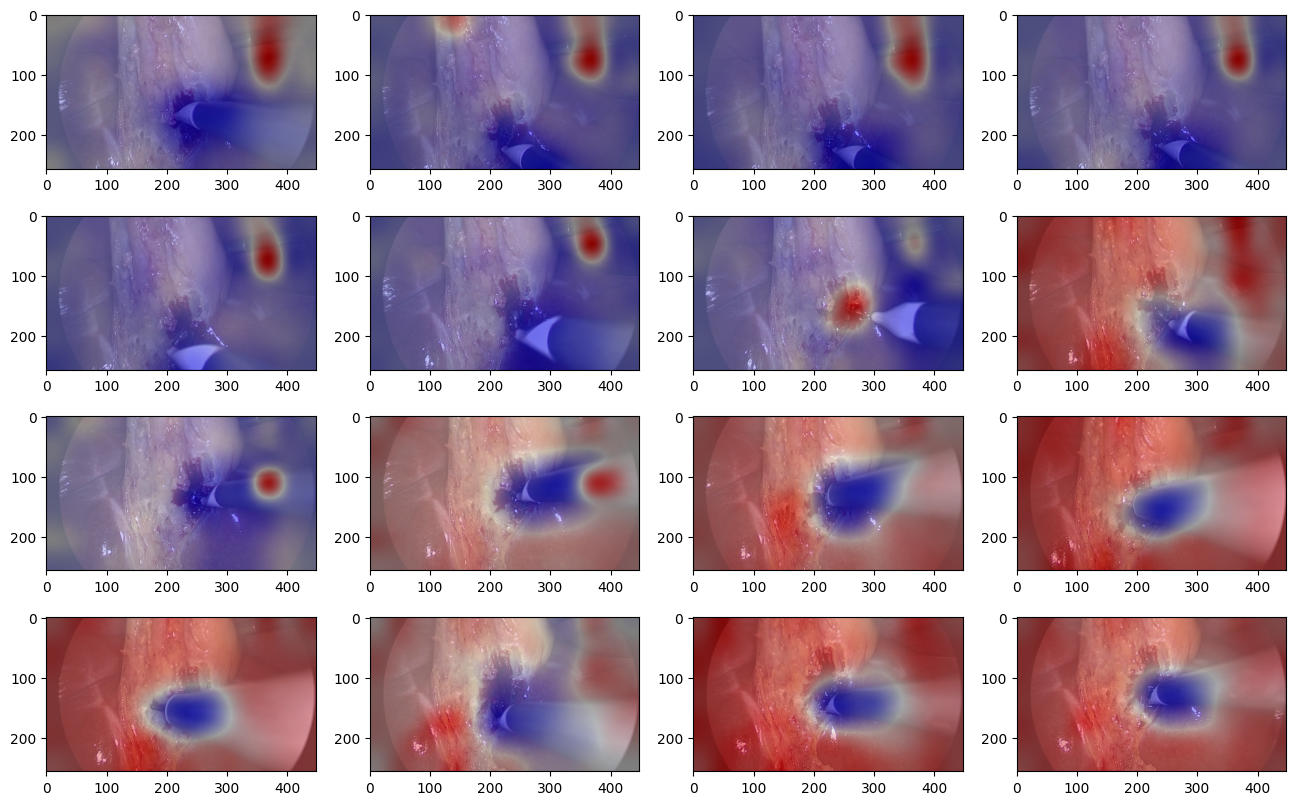

In [11]:
from PIL import  Image
import scipy.ndimage as ndimage

plt.subplots(4,4,figsize=(16,10))
for idx in range(0, 16):


    img = img_list[0][idx]
    label = label_i[0][idx]
    # plt.subplot(6,2,2*idx+1)
    # plt.imshow(img.numpy().astype(np.uint8))
    print(label)

    logits = logits_list[0][idx]
    logit  = tf.sigmoid(logits)

    # print(logit)

    loss_value = loss_fn(labels=label, logits=logits, pos_weight=class_weights)
    loss_value = tf.math.reduce_mean(loss_value)
    print("Loss Value")
    print(loss_value)

    plt.subplot(4,4,idx+1)
    heatmap = LHMaps[0][idx][:,:,0].numpy() * label[0].numpy()
    heatmap_image = Image.fromarray(heatmap*255)
    heatmap_image_resized = heatmap_image.resize((448, 256))
    gaussian_std=10
    heatmap_image_resized = ndimage.gaussian_filter(heatmap_image_resized, 
                                                    sigma=(gaussian_std, gaussian_std), 
                                                    order=0)
    heatmap_image_resized = np.asarray(heatmap_image_resized)
    transparency=0.5
    color_map='bwr'
    plt.imshow(img.numpy().astype(np.uint8))
    plt.imshow(heatmap_image_resized/255, alpha=transparency, cmap=color_map)

In [12]:
def generate_3dheatmap(LHMap, label):
    heatmap = LHMap * label
    heatmap = cv2.resize(heatmap, dsize=(448, 256), interpolation=cv2.INTER_LINEAR)
    
    heatmap = ((heatmap - heatmap.min()) * (1/(heatmap.max() - heatmap.min()) * 255)).astype('uint8')
    heatmap = cv2.merge((heatmap,heatmap,heatmap))
    
    return heatmap

In [13]:
def generate_bb(heatmap, orig_img, label_idx):
    colors    = [(255,0,0),(255,255,0),(0,0,255),(255,0,255),(255,128,0),(0,255,255)] 
    gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    rectangles = []
    size = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        
        # Size of rectangle is very small
        if w < 0.1 * orig_img.shape[0] or h < 0.1 * orig_img.shape[1]:
            continue
        
        # Size of rectangle is very small
        if w > 0.9 * orig_img.shape[0] or h > 0.9 * orig_img.shape[1]:
            continue
        
        rectangles.append([x,y,w,h])
        size.append(w*h)
        
    
        # cv2.rectangle(orig_img, (x, y), (x + w, y + h), colors[label_idx], 2)
    
    if len(size)!= 0:
        rectangle = rectangles[size.index(max(size))]
        print(rectangle)
        cv2.rectangle(orig_img, (x, y), (x + w, y + h), colors[label_idx], 2)
        
    return thresh

In [14]:
# plt.subplots(4,4,figsize=(16,10))
bb_imgs = []
img_labels = []

for batch_idx in range(0, BATCH_SIZE):
    for frame_idx in range(0, SEQUENCE_DEPTH):
        img = img_list[batch_idx][frame_idx]
        label = label_i[batch_idx][frame_idx]

        logits = logits_list[batch_idx][frame_idx]
        logit  = tf.sigmoid(logits)
        
        np_img = img.numpy().astype(np.uint8)
        
        for label_idx in range(0, 6):

            # plt.subplot(4,4,idx+1)
            # heatmap = LHMaps[0][idx+offset][:,:,0].numpy() * label[0].numpy()
            # heatmap = cv2.resize(heatmap, dsize=(448, 256), interpolation=cv2.INTER_LINEAR)
            
            # heatmap = ((heatmap - heatmap.min()) * (1/(heatmap.max() - heatmap.min()) * 255)).astype('uint8')
            # heatmap = cv2.merge((heatmap,heatmap,heatmap))
            
            heatmap3d = generate_3dheatmap(LHMaps[batch_idx][frame_idx][:,:,label_idx].numpy(), label[label_idx].numpy())
            
            
            thresh = generate_bb(heatmap3d, np_img, label_idx)
        
        bb_imgs.append(np_img)
        
        present_label_str = instruments[label == 1]
        img_labels.append(present_label_str)
        
        # plt.imshow(np_img)

/tmp/ipykernel_2194912/2670980659.py:5: RuntimeWarning: divide by zero encountered in divide
  heatmap = ((heatmap - heatmap.min()) * (1/(heatmap.max() - heatmap.min()) * 255)).astype('uint8')
/tmp/ipykernel_2194912/2670980659.py:5: RuntimeWarning: invalid value encountered in multiply
  heatmap = ((heatmap - heatmap.min()) * (1/(heatmap.max() - heatmap.min()) * 255)).astype('uint8')


[326, 0, 67, 114]
[320, 0, 71, 130]
[328, 0, 64, 109]
[331, 0, 61, 109]
[306, 0, 142, 256]
[198, 0, 192, 256]
[222, 112, 77, 83]
[196, 103, 187, 153]
[353, 145, 95, 111]
[204, 61, 179, 130]
[196, 69, 175, 135]
[168, 92, 163, 118]
[164, 111, 148, 97]
[334, 0, 114, 256]
[166, 0, 216, 256]
[184, 69, 179, 142]
[188, 84, 152, 107]
[171, 51, 181, 205]
[151, 69, 179, 153]
[164, 76, 205, 118]
[158, 55, 218, 153]
[184, 97, 165, 111]
[164, 95, 215, 161]
[309, 0, 139, 256]
[168, 0, 173, 256]
[167, 139, 147, 117]
[267, 59, 181, 197]
[184, 0, 207, 130]
[180, 37, 144, 169]
[187, 59, 183, 197]
[309, 0, 139, 256]
[155, 0, 227, 256]
[225, 90, 175, 166]
[189, 117, 170, 139]
[321, 0, 127, 117]
[192, 62, 161, 128]
[113, 0, 220, 130]
[186, 0, 163, 196]
[173, 102, 189, 154]
[190, 175, 150, 81]
[197, 87, 183, 169]
[177, 47, 202, 148]
[295, 50, 153, 206]
[179, 109, 177, 147]
[177, 97, 130, 99]
[202, 132, 165, 124]
[210, 103, 161, 153]
[231, 66, 151, 190]
[218, 145, 147, 111]
[356, 54, 92, 202]
[123, 0, 105, 1

In [15]:
for (img_list, (_, label_i, _, _, _)) in train_dataloader.take(1):
    print(img_list.numpy()[0].shape)
    break

[869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 10

In [16]:
from matplotlib import animation
from IPython.display import display, HTML

def plot_sequence_images(image_array, img_labels):
    ''' Display images sequence as an animation in jupyter notebook
    
    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    print(xpixels, ypixels)
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    # fig.suptitle('My First Animated Plot', size=26, y=0.87)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True, facecolor='#cfd98c')
    im = plt.figimage(image_array[0,:,:,:])
    
    # title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
    #             transform=ax.transAxes, ha="center")
    

    def animate(i):
        # gray = cv2.cvtColor(image_array[i], cv2.COLOR_RGB2GRAY)  
        # im.set_array(image_array[i])
        im.set_data(image_array[i,:,:,:].astype('uint8'))
        label_str = str(img_labels[i])
        # title.set_text(label_str)
        # im.set_array(gray)
        return im

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=350, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))
    return anim

In [17]:
bb_imgs = np.asarray(bb_imgs)
print(bb_imgs.shape)
type(bb_imgs)



(128, 256, 448, 3)


numpy.ndarray

256 448


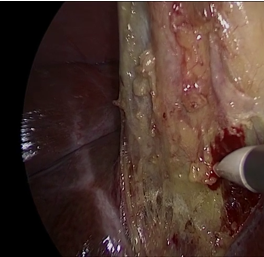

In [18]:
# anim = plot_sequence_images(img_list.numpy()[0])
anim = plot_sequence_images(bb_imgs, img_labels)

In [19]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='Me'), bitrate=1800)

# import module
from datetime import datetime

# get current date and time
current_datetime = datetime.now()
print("Current date & time : ", current_datetime)
  
# convert datetime obj to string
str_current_datetime = str(current_datetime)

# create a file object along with extension
file_name = "video" + str_current_datetime+ ".mp4"
anim.save(file_name, writer=writer)

Current date & time :  2023-04-21 22:08:09.958173


In [20]:
folder = "/home/tshah74/mip/CholecT50/videos/VID01"
onlyfiles = os.listdir(folder)
# onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
files = sorted(onlyfiles, key=lambda x: int(os.path.splitext(x)[0]))

print("Working with {0} images".format(len(files)))

Working with 1734 images


000040.png


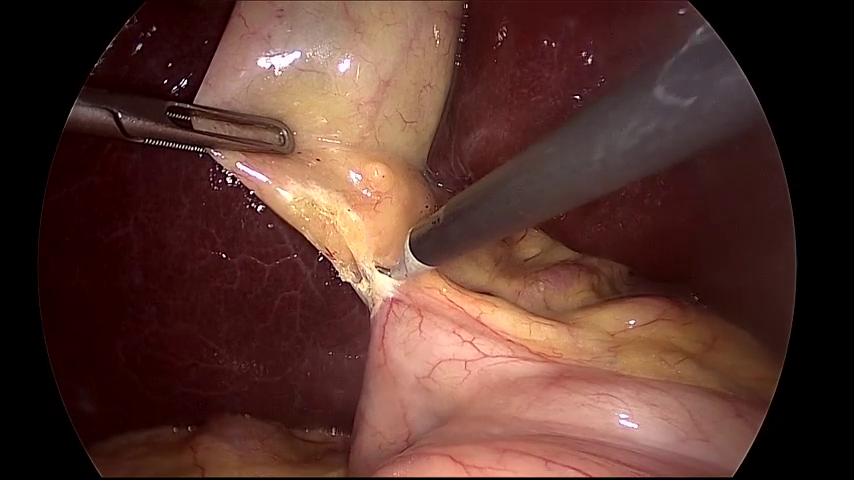

000041.png


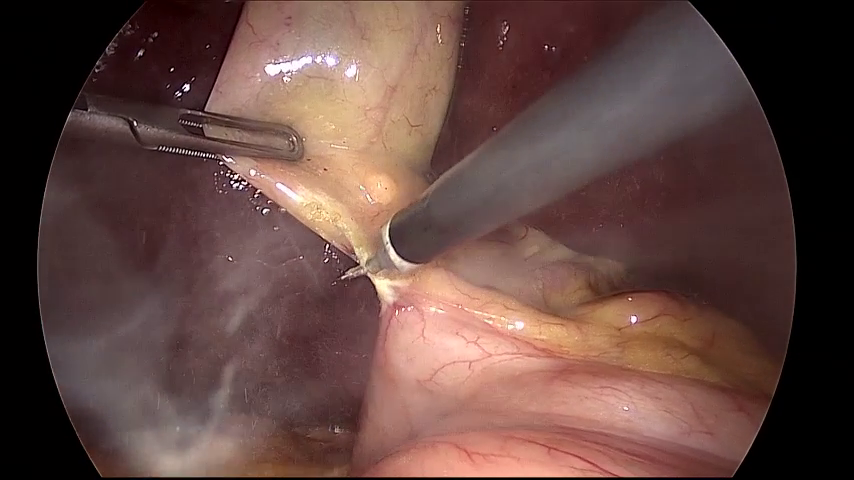

In [21]:
from IPython.display import display
from IPython.display import Image as _Imgdis

for i in range(40, 42):
    print(files[i])
    display(_Imgdis(filename=folder + "/" + files[i], width=448, height=256))

(480, 854, 3)


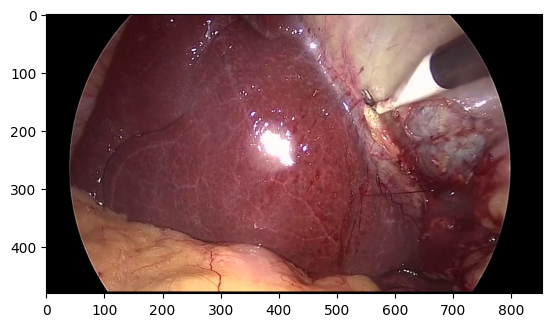

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = np.asarray(Image.open(folder + "/" + onlyfiles[i]))
imgplot = plt.imshow(img)

shape = img.shape
print(shape)

In [23]:
img_list = np.ndarray((128, 256, 448, 3))

for i in range(img_list.shape[0]):
    image = Image.open(folder + "/" + files[i])
    image = np.asarray(image.resize(size=(448,256)))
    img_list[i, :, :, :] =  image.astype('uint8')
    

In [24]:
for img, (triplet_label, label_i, verb_label, target_label, phase_label) in val_dataloader.take(1):
    print(label_i.numpy().shape)

[869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 10

In [25]:
import ivtmetrics
recognize  = ivtmetrics.Recognition(num_class=6)

for step, (img, (triplet_label, label_i, verb_label, target_label, phase_label)) in enumerate(val_dataloader):
    
  [predictions, LHMap] = model(img, training=False)  # Logits for this minibatch  
  predictions  = tf.sigmoid(predictions)
  # print(type(predictions.numpy().tolist()))
  if (predictions.numpy().shape[0] == BATCH_SIZE):
    #pass
    for i in range(BATCH_SIZE):
      recognize.update(label_i[i,:,:].numpy().tolist(), predictions[i,:,:].numpy().tolist())
  else:
    print(predictions.numpy().shape[0])
  
  if (step % 50 == 0):
    print(step*SEQUENCE_DEPTH*BATCH_SIZE)

[869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 10

In [26]:
results_i = recognize.compute_AP('ivt')
print("instrument per class AP", results_i["AP"]*100)
print("instrument mean AP", results_i["mAP"])

instrument per class AP [87.22335336 25.6648583  46.9278608          nan         nan 29.91847126]
instrument mean AP 0.47433635928861334


/home/tshah74/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/tshah74/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [27]:
99.8 95.6 99.9 76.1 97.1 77.4
90.5 .9 90.9 70.6 90.4 72.9

SyntaxError: invalid syntax (4283756629.py, line 1)